In [28]:
# https://github.com/Technical-Incerto-Reading-Club/code-examples/blob/main/Session%205/Chapter%2010%20-%20Diagnosing%20the%20SP500%20-%20FMcG.ipynb.ipynb

In [82]:
from copy import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import kurtosis

In [74]:
def get_SP500_daily_returns():
    df = yf.download(
        tickers="^GSPC",
        period="max",
        interval="1d",
        auto_adjust=True,
    )
    df["returns_log"] = np.log(df["Close"] / df["Close"].shift(1))
    df["returns"] = df["Close"] / df["Close"].shift(1) - 1
    df = df.dropna()
    return df


# taken from: https://github.com/FergM/fattails/blob/87fddc034937a6d25f2e62c8aad3d60f1aac1856/fattails/metrics.py
def get_survival_probability(arr):
    """Calculate sample probability of X >= x, for each value in `arr`.
    Duplicate values are treated as ascending values based on
    their position in `arr`.
    Parameters
    ----------
    arr : array_like
        Numeric values on the real number line
    Returns
    -------
    survival_probability_sr : Pandas Series
    """
    # ---------------------------------------------------
    # PREPARE
    # Sort values from low to high. Keep track of original
    # index and order.

    arr = copy(arr)  # Copy to avoid accidental mutation
    sr = pd.Series(arr)  # Ensure we have a pandas series

    # Keep a copy of the original index
    input_index = sr.index.copy()

    # Create index of input order
    df = sr.reset_index(name="input_values")  # Keeps the input index as a column
    df.index.name = "input_order"  # Name the new index

    # Sort from low to high and reindex
    df = df.sort_values(by="input_values")  # sort from low to high
    df = df.reset_index()
    df.index.name = "sorted_order"  # Name the new index

    # ---------------------------------------------------
    # CALCULATE

    # Label relative positions
    gap_count = len(sr) + 1  # Think of the Posts and Fences analogy
    df["left_gap_count"] = df.index + 1  # Count values <= x
    df["right_gap_count"] = gap_count - df.left_gap_count  # Count values >= x

    # Get survival Probability
    df["survival_probability"] = df.right_gap_count / gap_count

    # ---------------------------------------------------
    # FORMAT THE OUTPUT

    # Reset Input Order and Index
    df = df.sort_values(by="input_order")  # sort from low to high
    df.index = input_index

    # Extract the output series
    survival_probability_sr = df.survival_probability

    return survival_probability_sr


def plot_MS_moments(data):
    """Plot cumulative max/sum ratio of 1st to 4th moments
    Parameters
    ----------
    data : array-like
        Numeric values whose moments you want to calculate.
        Must be:
            * a valid input to `fattails.metrics.calculate_moments`.
            * 1-dimensional
    Returns
    -------
    subplots : np.array
        2*2 array of matplotlib subplots
    """

    # Calculate Moments
    moments_df = calculate_moments(data)

    # Calculate Max/Sum Ratio
    max_over_sum_df = moments_df.apply(max_over_sum)

    # Plot Max over Sum
    subplots = max_over_sum_df.plot(subplots=True, layout=[2, 2], figsize=[12.0, 8.0])

    return subplots


def calculate_moments(data, moments=[1, 2, 3, 4], absolute_values=True):
    """Create dataframe with a column for each moment.
    Parameters
    ----------
    data : array-like
        Numeric values whose moments you want to calculate.
        Must be 1-dimensional
    moments : list-like of numbers
        Each moment has its own column in the output.
    absolute_values : , default True
    Returns
    -------
    moments_df : DataFrame
        Elementwise evaluation of x**p for each x in data and p in moments
        Number of rows = len(data)
        Number of columns = len(moments)
    """

    # FORMAT THE INPUT
    sr = pd.Series(data)
    if absolute_values:
        # Take absolute values (this matters for odd moments)
        sr = sr.abs()

    # CALCULATE MOMENTS
    df = pd.DataFrame()
    # Add columns with the moments for each datapoint
    for moment in moments:
        df[f"moment_{moment}"] = sr**moment

    return df


def max_over_sum(data, reset_index=False):
    """Calculate cumulative max over sum
    Parameters
    ----------
    data : array-like
        Numeric values whose moments you want to calculate.
        Must be 1-dimensional
    reset_index : bool
        Reset the index so it matches the cumulative count of your dataset size
        Selecting True will give you an output index starting at 1
    Returns
    -------
    max_over_sum : Series
        Series with cumulative maximum divided by cumulative sum.
        Cumulative sample size is assigned as the series' index.
    """
    sr = pd.Series(data)

    if reset_index:
        # Replace index with Cumulative Sample Size
        sr.reset_index(drop=True, inplace=True)
        sr.index += 1
        sr.index.rename("cumulative_sample_size", inplace=True)

    # Calculate
    max_over_sum = sr.cummax() / sr.cumsum()

    return max_over_sum


def grouped_kurtosis(df, window_size):
    """Calculate the kurtosis of log returns for different lags."""

    df = df.copy()

    df["window_number"] = np.arange(0, len(df)) // window_size

    kurt = df.groupby(df.window_number).sum().apply(kurtosis, fisher=False)

    return kurt


def largest_drawdown(sr):
    """Calculate the greatest drop between a given value and the smallest value after it."""

    # Smallest value after each value (inclusive)
    reverse_cummin = sr[::-1].cummin()[::-1]

    # Largest drop possible (>=0)
    largest_drawdown = max(sr - reverse_cummin)

    return largest_drawdown


def apply_to_grouped_rows(sr, window_size, func):
    """Apply func to groups of every n rows."""

    sr = sr.copy()

    # Get Series Name
    if not sr.name:
        sr.rename("input_sr", inplace=True)

    input_name = sr.name

    df = sr.to_frame()

    df["window_number"] = np.arange(0, len(df)) // window_size

    return df[input_name].groupby(df.window_number).apply(func)

In [46]:
df = get_SP500_daily_returns()

[*********************100%***********************]  1 of 1 completed


In [47]:
df.loc["1960-01-05"]

Open           6.039000e+01
High           6.039000e+01
Low            6.039000e+01
Close          6.039000e+01
Volume         3.710000e+06
returns_log    7.980085e-03
returns        8.012010e-03
Name: 1960-01-05 00:00:00, dtype: float64

# 10.1 Paretianity and Moments

In [48]:
sr = df.returns.abs() * 100
sr_df = sr.to_frame()
sr_df["survival_probability"] = get_survival_probability(sr_df.returns)
sr_df = sr_df.sort_values(by="returns")
sr_df

,returns,survival_probability
Date,,
1953-06-30,0.000000,0.999946
1959-08-31,0.000000,0.999891
1956-12-17,0.000000,0.999837
1964-10-27,0.000000,0.999782
1954-06-01,0.000000,0.999728
...,...,...
2020-03-12,9.511268,0.000272
2008-10-28,10.789006,0.000218
2008-10-13,11.580037,0.000163


<AxesSubplot:title={'center':'SP500 Daily Returns'}, xlabel='Daily Return %', ylabel='Probability of >= X'>

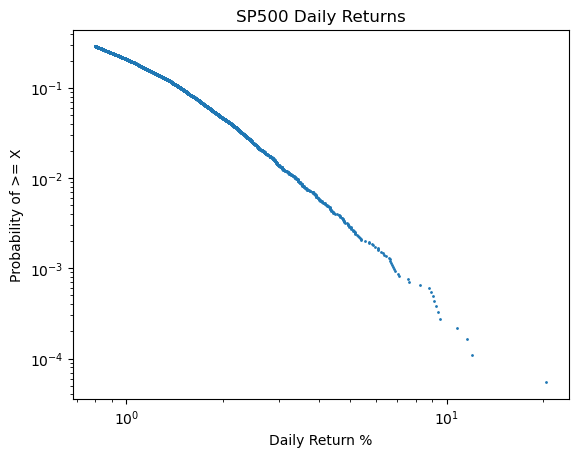

In [49]:
selection = sr_df.returns > 0.8
right_tail = sr_df.loc[selection]
right_tail.plot(
    x="returns",
    y="survival_probability",
    xlabel="Daily Return %",
    ylabel="Probability of >= X",
    title="SP500 Daily Returns",
    kind="scatter",
    loglog=True,
    s=1,
)

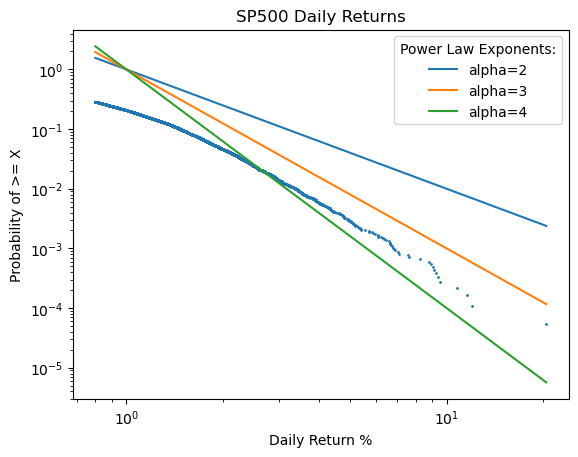

In [50]:
ax = right_tail.plot(
    x="returns",
    y="survival_probability",
    xlabel="Daily Return %",
    ylabel="Probability of >= X",
    title="SP500 Daily Returns",
    kind="scatter",
    loglog=True,
    s=1,
)

for alpha in [2, 3, 4]:
    x_min = right_tail.returns.min()
    x_max = right_tail.returns.max()

    slope = -alpha  # alpha = -slope
    x_values = np.linspace(x_min, x_max)
    y_values = x_values**slope
    ax.plot(x_values, y_values, label=f"alpha={alpha}")


ax.legend(title="Power Law Exponents:")

# 10.2 Convergence Tests

In [52]:
kurtosis_df = pd.DataFrame({"window_size": range(1, 100 + 1)})
kurtosis_df

,window_size
0,1
1,2
2,3
3,4
4,5
...,...
95,96
96,97
97,98
98,99


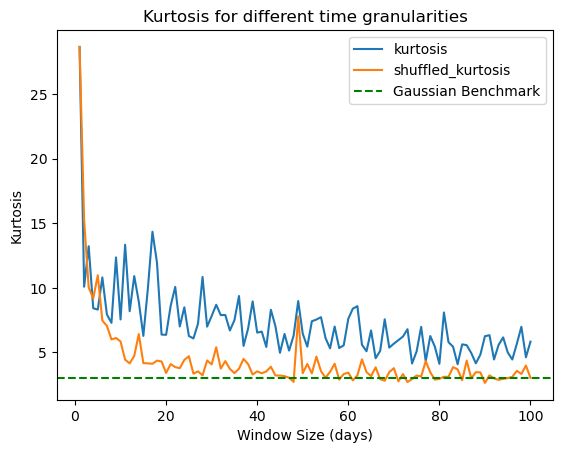

In [61]:
df_log = df.returns_log.to_frame()

kurtosis_df["kurtosis"] = kurtosis_df.window_size.apply(
    lambda window_size: grouped_kurtosis(df_log, window_size)
)

kurtosis_df["shuffled_kurtosis"] = kurtosis_df.window_size.apply(
    lambda window_size: grouped_kurtosis(df_log.sample(frac=1), window_size)
)

trace_columns = ["kurtosis", "shuffled_kurtosis"]

ax = kurtosis_df.plot(
    x="window_size",
    y=trace_columns,
    xlabel="Window Size (days)",
    ylabel="Kurtosis",
    title="Kurtosis for different time granularities",
)

ax.axhline(3, color="g", linestyle="--", label="Gaussian Benchmark")

ax.legend()

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

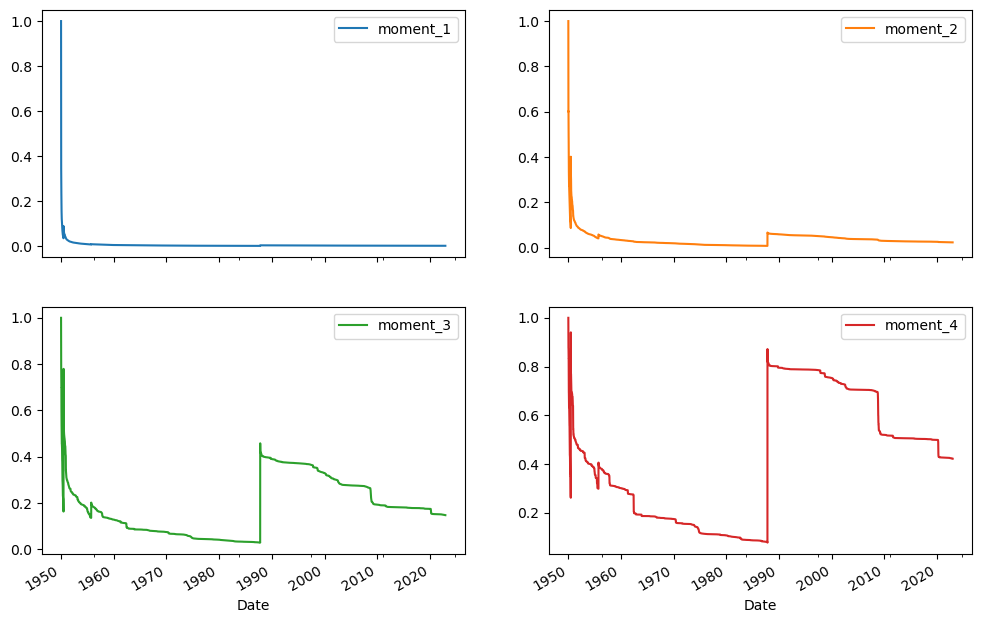

In [62]:
plot_MS_moments(df.returns)

In [66]:
dfr = df.returns.to_frame()

In [67]:
window_df = pd.DataFrame({"window_size": range(1, 100 + 1)})
window_df

,window_size
0,1
1,2
2,3
3,4
4,5
...,...
95,96
96,97
97,98
98,99


In [76]:
window_size = 252

drawdown_sr = apply_to_grouped_rows(dfr.returns, window_size, func=largest_drawdown)
drawdown_sr

window_number
0     0.068868
1     0.043755
2     0.033989
3     0.044698
4     0.053054
        ...   
68    0.074350
69    0.051210
70    0.212712
71    0.048739
72    0.073800
Name: returns, Length: 73, dtype: float64

<AxesSubplot:title={'center':'Maximum Drawdown: Groups of 252 business days'}, xlabel='window_number'>

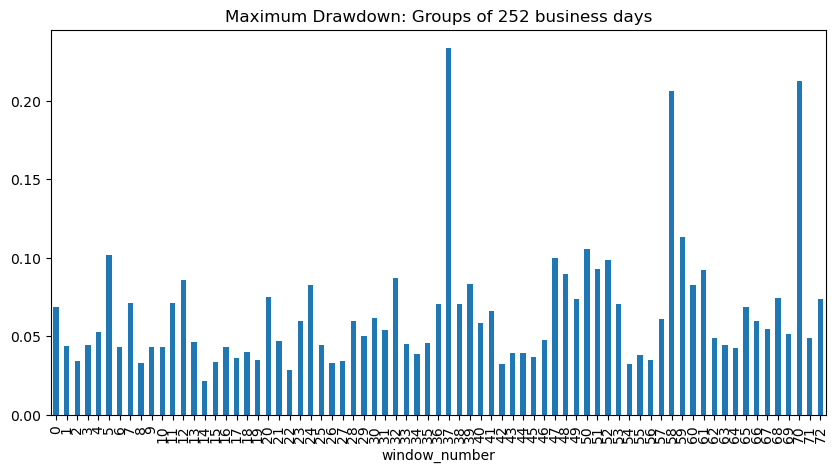

In [77]:
drawdown_sr.plot(
    kind="bar",
    figsize=(10, 5),
    title=f"Maximum Drawdown: Groups of {window_size} business days",
)

In [78]:
sr = df.returns

drawdown_dict = {}
for window_size in [5, 30, 100, 252]:

    drawdown_dict[window_size] = apply_to_grouped_rows(
        sr, window_size, largest_drawdown
    )

drawdown_df = pd.DataFrame(drawdown_dict)
drawdown_df.columns.name = "window_size"
drawdown_df

window_size,5,30,100,252
window_number,,,,
0,0.014332,0.030714,0.030714,0.068868
1,0.022833,0.019622,0.068868,0.043755
2,0.005324,0.022687,0.047655,0.033989
3,0.010128,0.068868,0.032487,0.044698
4,0.015754,0.048163,0.033471,0.053054
...,...,...,...,...
3666,0.046194,NaN,NaN,NaN
3667,0.016965,NaN,NaN,NaN
3668,0.029024,NaN,NaN,NaN


In [79]:
drawdown_df.max()

window_size
5      0.212712
30     0.221759
100    0.233522
252    0.233522
dtype: float64

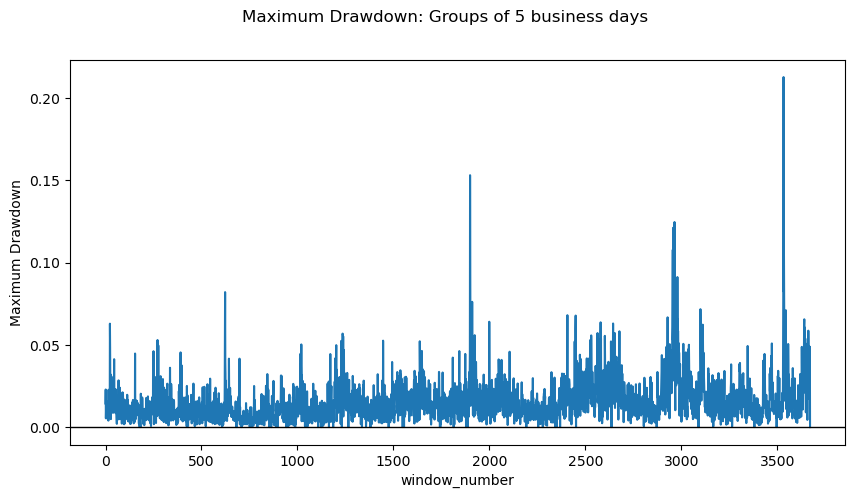

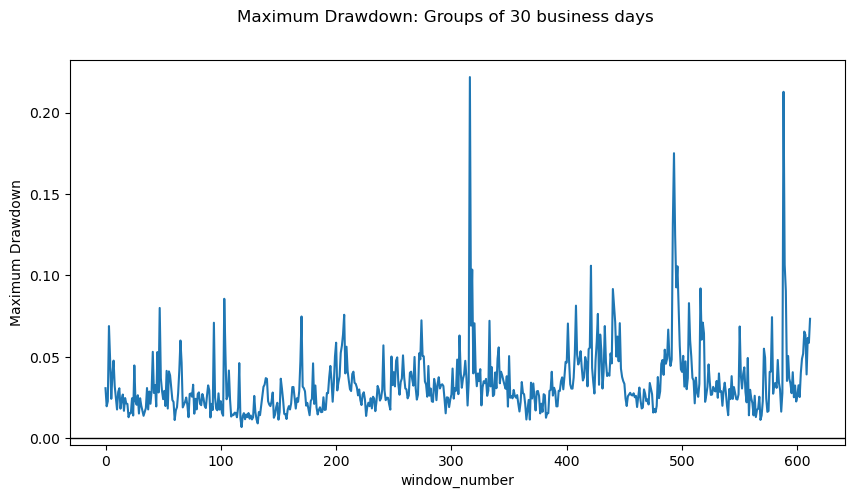

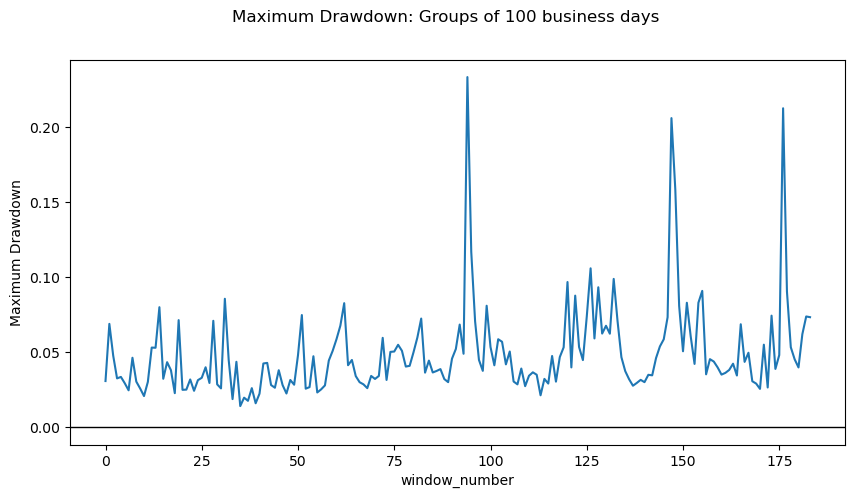

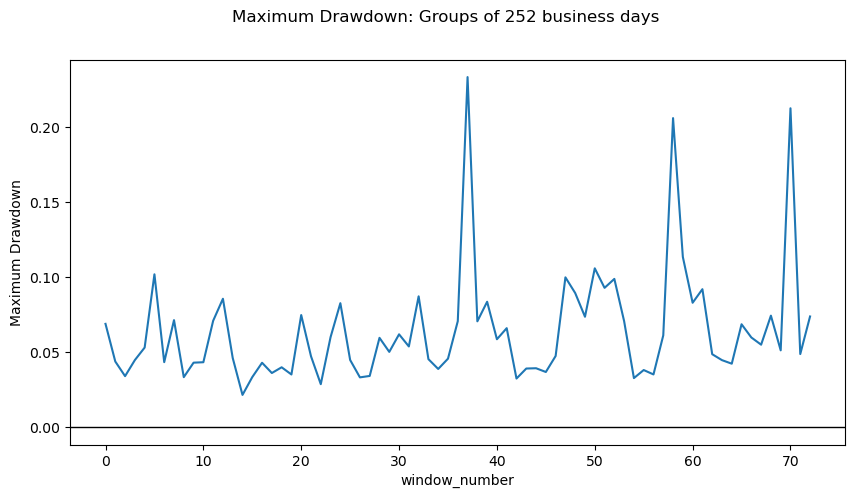

In [83]:
for col in drawdown_df.columns:

    ax = (
        drawdown_df[col]
        .dropna()
        .plot(
            subplots=True,
            figsize=(10, 5),
            ylabel="Maximum Drawdown",
            title=f"Maximum Drawdown: Groups of {col} business days",
        )
    )

    ax[0].axhline(0, color="k", linewidth=1)
    plt.show()